<a href="https://colab.research.google.com/github/Pugianf/Big_Data_and_Public_Sector_III-Economic_Development/blob/main/Aula_3_1_2021_12_07_DividaPublica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de Crescimento Econômico: **A Importância da Dívida Pública** 

Países com mais dívida crescem menos? Há um nível ótimo de dívida? A dívida de um país sequer importa?

Para começar a arranhar a superfície dessas perguntas, vamos usar a base de dados do [World Economic Outlook (WEO)](https://www.imf.org/en/Publications/SPROLLs/world-economic-outlook-databases#sort=%40imfdate%20descending) do FMI.

Vamos focar no período de 2000 a 2015 a fim de compreender todo o período pré e pós crise de 2008.

----

## Leitura dos Dados

In [ ]:
## Atualizando scipy
from IPython.display import clear_output # limpa o output de uma célula
!pip uninstall scipy -y
!pip install scipy

clear_output()  # limpando o texto

In [ ]:
## Importando o que for necessário
# Manipulação de dados
import pandas as pd
import numpy as np

# Testes e regressões
from scipy import stats
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices

# Gráficos
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import style

style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Lendo os dados
sCaminho = '/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoIII/Códigos/Aula 3 - 07_12_2021/'
sArquivo = "WEOOct16.dta"

## Lendo o DataFrame
data = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {data.shape[0]}; Colunas: {data.shape[1]}")

Linhas: 8022; Colunas: 48


In [ ]:
## Vendo o DataFrame
data.head(10)

,ISO,Country,year,BCA,BCA_NGDPD,FLIBOR6,GGR,GGR_NGDP,GGSB,GGSB_NPGDP,GGX,GGX_NGDP,GGXCNL,GGXCNL_NGDP,GGXONLB,GGXONLB_NGDP,GGXWDG,GGXWDG_NGDP,GGXWDN,GGXWDN_NGDP,LE,LP,LUR,NGAP_NPGDP,NGDP,NGDP_D,NGDP_FY,NGDP_R,NGDP_RPCH,NGDPD,NGDPDPC,NGDPPC,NGDPRPC,NGSD_NGDP,NID_NGDP,PCPI,PCPIE,PCPIEPCH,PCPIPCH,PPPEX,PPPGDP,PPPPC,PPPSH,TM_RPCH,TMG_RPCH,TX_RPCH,TXG_RPCH,group
0,AFG,Afghanistan,1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
1,AFG,Afghanistan,1981.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
2,AFG,Afghanistan,1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
3,AFG,Afghanistan,1983.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
4,AFG,Afghanistan,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
5,AFG,Afghanistan,1985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
6,AFG,Afghanistan,1986.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
7,AFG,Afghanistan,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
8,AFG,Afghanistan,1988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East
9,AFG,Afghanistan,1989.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East


## Limpeza dos Dados

In [ ]:
## Vamos selecionar apenas as colunas que interessam para a nossa análise
data = data[["ISO", "Country", "year", "GGXWDG_NGDP", "NGDP_RPCH", "LP", "NGDP_R", "group"]].copy()

## Renomeando para ficar intelígivel
data.rename(columns={
    "GGXWDG_NGDP": "Div_PIB",
    "NGDP_RPCH": "Cresc",  # taxa de crescimento do PIB
    "LP": "Pop",
    "NGDP_R": "PIB",
    "group": "grupo"
}, inplace=True)

## Vendo o resultado
data

,ISO,Country,year,Div_PIB,Cresc,Pop,PIB,grupo
0,AFG,Afghanistan,1980.0,NaN,NaN,NaN,NaN,Middle East
1,AFG,Afghanistan,1981.0,NaN,NaN,NaN,NaN,Middle East
2,AFG,Afghanistan,1982.0,NaN,NaN,NaN,NaN,Middle East
3,AFG,Afghanistan,1983.0,NaN,NaN,NaN,NaN,Middle East
4,AFG,Afghanistan,1984.0,NaN,NaN,NaN,NaN,Middle East
...,...,...,...,...,...,...,...,...
8017,ZWE,Zimbabwe,2017.0,57.587,-2.524,14.877,11.981,Sub-Saharan
8018,ZWE,Zimbabwe,2018.0,57.056,0.007,15.263,11.982,Sub-Saharan
8019,ZWE,Zimbabwe,2019.0,58.202,1.268,15.658,12.134,Sub-Saharan
8020,ZWE,Zimbabwe,2020.0,56.637,1.467,16.064,12.311,Sub-Saharan


In [ ]:
## Vamos também filtrar apenas os anos de 2000 a 2015...
data = data.query("year > 1999 & year < 2016").copy()

## ... e criar uma coluna que diz a dívida em termos absolutos
data["Div"] = data["Div_PIB"] * data["PIB"]

## Vendo resultado
data

,ISO,Country,year,Div_PIB,Cresc,Pop,PIB,grupo,Div
20,AFG,Afghanistan,2000.0,NaN,NaN,NaN,NaN,Middle East,NaN
21,AFG,Afghanistan,2001.0,NaN,NaN,NaN,NaN,Middle East,NaN
22,AFG,Afghanistan,2002.0,280.979,NaN,22.203,182.842,Middle East,51374.762318
23,AFG,Afghanistan,2003.0,273.471,8.692,23.116,198.736,Middle East,54348.532656
24,AFG,Afghanistan,2004.0,243.438,0.671,24.019,200.069,Middle East,48704.397222
...,...,...,...,...,...,...,...,...,...
8011,ZWE,Zimbabwe,2011.0,51.761,11.905,12.459,10.167,Sub-Saharan,526.254087
8012,ZWE,Zimbabwe,2012.0,56.730,10.565,13.061,11.241,Sub-Saharan,637.701930
8013,ZWE,Zimbabwe,2013.0,54.559,4.484,13.430,11.745,Sub-Saharan,640.795455
8014,ZWE,Zimbabwe,2014.0,55.273,3.850,13.778,12.197,Sub-Saharan,674.164781


In [ ]:
## Por fim, vemos que há alguns países sem observações para alguns anos
## Para contornar esse problema, vamos usar apenas países com dados completos

# Contando NaNs
data["nans"] = data[["Div_PIB"]].isnull().groupby(data["ISO"]).transform('sum')
data

,ISO,Country,year,Div_PIB,Cresc,Pop,PIB,grupo,Div,nans
20,AFG,Afghanistan,2000.0,NaN,NaN,NaN,NaN,Middle East,NaN,2
21,AFG,Afghanistan,2001.0,NaN,NaN,NaN,NaN,Middle East,NaN,2
22,AFG,Afghanistan,2002.0,280.979,NaN,22.203,182.842,Middle East,51374.762318,2
23,AFG,Afghanistan,2003.0,273.471,8.692,23.116,198.736,Middle East,54348.532656,2
24,AFG,Afghanistan,2004.0,243.438,0.671,24.019,200.069,Middle East,48704.397222,2
...,...,...,...,...,...,...,...,...,...,...
8011,ZWE,Zimbabwe,2011.0,51.761,11.905,12.459,10.167,Sub-Saharan,526.254087,5
8012,ZWE,Zimbabwe,2012.0,56.730,10.565,13.061,11.241,Sub-Saharan,637.701930,5
8013,ZWE,Zimbabwe,2013.0,54.559,4.484,13.430,11.745,Sub-Saharan,640.795455,5
8014,ZWE,Zimbabwe,2014.0,55.273,3.850,13.778,12.197,Sub-Saharan,674.164781,5


In [ ]:
## Retirando observações com ao menos 1 nan
data = data.query("nans == 0").copy()
data

,ISO,Country,year,Div_PIB,Cresc,Pop,PIB,grupo,Div,nans
62,AGO,Angola,2000.0,104.542,3.055,17.050,459.289,Sub-Saharan,48014.990638,0
63,AGO,Angola,2001.0,102.053,4.206,17.561,478.607,Sub-Saharan,48843.280171,0
64,AGO,Angola,2002.0,70.948,13.666,18.088,544.012,Sub-Saharan,38596.563376,0
65,AGO,Angola,2003.0,68.692,5.248,18.631,572.559,Sub-Saharan,39330.222828,0
66,AGO,Angola,2004.0,51.954,10.879,19.189,634.851,Sub-Saharan,32983.048854,0
...,...,...,...,...,...,...,...,...,...,...
7969,ZMB,Zambia,2011.0,20.803,5.616,14.344,102.675,Sub-Saharan,2135.948025,0
7970,ZMB,Zambia,2012.0,24.911,7.573,14.787,110.450,Sub-Saharan,2751.419950,0
7971,ZMB,Zambia,2013.0,25.915,5.132,15.246,116.118,Sub-Saharan,3009.197970,0
7972,ZMB,Zambia,2014.0,33.606,5.025,15.721,121.953,Sub-Saharan,4098.352518,0


In [ ]:
## Por fim, vamos tirar todos os países com menos de 5 milhões de habitantes em 2000
## Criando lista dos países com mais de 5 milhões de habitantes

## Selecionando apenas os dados de 2000
dfPaisesMais5Milhoes2000 = data.query('year == 2000')

## Pegando apenas os países com menos de 5 milhões de habitantes
dfPaisesMais5Milhoes2000 = dfPaisesMais5Milhoes2000.query("Pop >= 5")

## Vetor com os nomes dos países
vPaisesMais5Milhoes2000 = np.array(dfPaisesMais5Milhoes2000["Country"])

## Vendo resultados
print(f"Número de países: {vPaisesMais5Milhoes2000.shape[0]}")
vPaisesMais5Milhoes2000

Número de países: 90


array(['Angola', 'Argentina', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bulgaria', 'Bolivia', 'Brazil',
       'Canada', 'Switzerland', 'Chile', 'China', "C<f4>te d'Ivoire",
       'Cameroon', 'Democratic Republic of the Congo', 'Colombia',
       'Czech Republic', 'Germany', 'Denmark', 'Dominican Republic',
       'Algeria', 'Spain', 'Ethiopia', 'Finland', 'France',
       'United Kingdom', 'Ghana', 'Guinea', 'Greece', 'Guatemala',
       'Honduras', 'Haiti', 'Hungary', 'Indonesia', 'India',
       'Islamic Republic of Iran', 'Israel', 'Italy', 'Japan', 'Kenya',
       'Cambodia', 'Korea', 'Libya', 'Sri Lanka', 'Morocco', 'Madagascar',
       'Mexico', 'Mali', 'Myanmar', 'Mozambique', 'Malaysia', 'Niger',
       'Nigeria', 'Nicaragua', 'Netherlands', 'Nepal', 'Pakistan', 'Peru',
       'Philippines', 'Papua New Guinea', 'Poland', 'Portugal',
       'Paraguay', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Sudan',
       'Senegal', 'El Salvador', 'S

In [ ]:
## Selecionando apenas estes no DataFrame
data = data.loc[data["Country"].isin(vPaisesMais5Milhoes2000)].copy()
data

,ISO,Country,year,Div_PIB,Cresc,Pop,PIB,grupo,Div,nans
62,AGO,Angola,2000.0,104.542,3.055,17.050,459.289,Sub-Saharan,48014.990638,0
63,AGO,Angola,2001.0,102.053,4.206,17.561,478.607,Sub-Saharan,48843.280171,0
64,AGO,Angola,2002.0,70.948,13.666,18.088,544.012,Sub-Saharan,38596.563376,0
65,AGO,Angola,2003.0,68.692,5.248,18.631,572.559,Sub-Saharan,39330.222828,0
66,AGO,Angola,2004.0,51.954,10.879,19.189,634.851,Sub-Saharan,32983.048854,0
...,...,...,...,...,...,...,...,...,...,...
7969,ZMB,Zambia,2011.0,20.803,5.616,14.344,102.675,Sub-Saharan,2135.948025,0
7970,ZMB,Zambia,2012.0,24.911,7.573,14.787,110.450,Sub-Saharan,2751.419950,0
7971,ZMB,Zambia,2013.0,25.915,5.132,15.246,116.118,Sub-Saharan,3009.197970,0
7972,ZMB,Zambia,2014.0,33.606,5.025,15.721,121.953,Sub-Saharan,4098.352518,0


## Análises

### Efeito da Crise de 2008 sobre a Dívida Pública

Será que a dívida pública subiu de forma exagerada entre 2007 e 2009?

Para isso, vamos comparar as variações de dívida entre 2007 e 2009 com aquelas ocorridas entre 2004 e 2006.

In [ ]:
## Pegando apenas os dados de 2004, 2006, 2007 e 2009
dataVarDiv = data[["Country", "grupo", "year", "Div"]].loc[data["year"].isin([2004, 2006, 2007, 2009])]
dataVarDiv

,Country,grupo,year,Div
66,Angola,Sub-Saharan,2004.0,32983.048854
68,Angola,Sub-Saharan,2006.0,16948.082620
69,Angola,Sub-Saharan,2007.0,17853.454962
71,Angola,Sub-Saharan,2009.0,29416.694490
192,Argentina,Latin America and Caribbean,2004.0,56814.728340
...,...,...,...,...
7925,South Africa,Sub-Saharan,2009.0,80216.191242
7962,Zambia,Sub-Saharan,2004.0,1150.365164
7964,Zambia,Sub-Saharan,2006.0,1727.580894
7965,Zambia,Sub-Saharan,2007.0,1642.224296


In [ ]:
## Pivottando 
dataVarDivPivot = dataVarDiv.pivot(index=['Country', 'grupo'], columns='year', values='Div')
dataVarDivPivot

,year,2004.0,2006.0,2007.0,2009.0
Country,grupo,,,,
Angola,Sub-Saharan,3.298305e+04,1.694808e+04,1.785345e+04,2.941669e+04
Argentina,Latin America and Caribbean,5.681473e+04,3.344672e+04,3.162083e+04,3.277442e+04
Australia,Advanced,1.454116e+04,1.285957e+04,1.305383e+04,2.357805e+04
Austria,Advanced,1.752894e+04,1.914428e+04,1.917597e+04,2.304504e+04
Azerbaijan,Commonwealth of Independent States,1.574764e+02,1.373845e+02,1.390929e+02,2.512219e+02
...,...,...,...,...,...
Venezuela,Latin America and Caribbean,1.778562e+03,1.311560e+03,1.465601e+03,1.562095e+03
Vietnam,Emerging Asia,5.531377e+07,6.527275e+07,7.445982e+07,9.158020e+07
Yemen,Middle East,1.555584e+04,1.329276e+04,1.359058e+04,1.804674e+04


In [ ]:
## Calculando variação percentual da dívida entre os períodos de interesse
dataVarDivPivot["var04_06"] = 100 * (dataVarDivPivot[2006] / dataVarDivPivot[2004] - 1)
dataVarDivPivot["var07_09"] = 100 * (dataVarDivPivot[2009] / dataVarDivPivot[2007] - 1)

# Dummy que indica se a variação entre 2007 e 2009 foi maior que entre 2004 e 2006
dataVarDivPivot["CriseDivida"] = np.where(
    dataVarDivPivot["var07_09"] > dataVarDivPivot["var04_06"],
    1,
    0
)

dataVarDivPivot

,year,2004.0,2006.0,2007.0,2009.0,var04_06,var07_09,CriseDivida
Country,grupo,,,,,,,
Angola,Sub-Saharan,3.298305e+04,1.694808e+04,1.785345e+04,2.941669e+04,-48.615779,64.767517,1
Argentina,Latin America and Caribbean,5.681473e+04,3.344672e+04,3.162083e+04,3.277442e+04,-41.130188,3.648196,1
Australia,Advanced,1.454116e+04,1.285957e+04,1.305383e+04,2.357805e+04,-11.564349,80.621758,1
Austria,Advanced,1.752894e+04,1.914428e+04,1.917597e+04,2.304504e+04,9.215269,20.176629,1
Azerbaijan,Commonwealth of Independent States,1.574764e+02,1.373845e+02,1.390929e+02,2.512219e+02,-12.758641,80.614443,1
...,...,...,...,...,...,...,...,...
Venezuela,Latin America and Caribbean,1.778562e+03,1.311560e+03,1.465601e+03,1.562095e+03,-26.257278,6.583889,1
Vietnam,Emerging Asia,5.531377e+07,6.527275e+07,7.445982e+07,9.158020e+07,18.004524,22.992771,1
Yemen,Middle East,1.555584e+04,1.329276e+04,1.359058e+04,1.804674e+04,-14.548056,32.788563,1


In [ ]:
## Descrevendo o dataframe
dataVarDivPivot[["var04_06", "var07_09", "CriseDivida"]].describe()

# 88,88889% dos países da amostras (80 / 90) tiveram uma dívida maior com a críse;
# De fato, a variação média entre 2004 e 2006 foi de -13,5%, enquanto entre 2007 e 2009 foi de +16,45%

year,var04_06,var07_09,CriseDivida
count,90.000000,90.000000,90.000000
mean,-13.507988,16.456833,0.888889
std,24.323275,27.386668,0.316030
min,-75.194475,-78.425072,0.000000
25%,-29.643345,2.952903,1.000000
50%,-8.745771,12.783186,1.000000
75%,3.994139,23.241335,1.000000
max,50.176739,150.579039,1.000000


### Dívida afeta a taxa de crescimento do PIB?

Vamos usar os dados médios entre 2000 e 2015 para responder essa pergunta!

#### **Correlação** entre Dívida Pública e (Crescimento do) PIB

In [ ]:
## Calculando médias entre 2000 e 2015
dataMedia = data.groupby(["Country", "grupo"], as_index=False)[["Div_PIB", "Cresc", "PIB"]].mean()

## Removendo Nans
dataMedia.dropna(axis=0, inplace=True)
dataMedia

,Country,grupo,Div_PIB,Cresc,PIB
19,Algeria,Middle East,23.966812,3.693125,5.571154e+03
27,Angola,Sub-Saharan,47.087438,8.873813,1.068929e+03
39,Argentina,Latin America and Caribbean,63.837625,2.704562,5.925812e+02
49,Australia,Advanced,19.455000,2.947687,1.351727e+03
56,Austria,Advanced,73.424813,1.483000,2.862146e+02
...,...,...,...,...,...
1289,Uzbekistan,Commonwealth of Independent States,23.510375,7.112500,8.119581e+02
1306,Venezuela,Latin America and Caribbean,42.017187,2.457375,5.136181e+01
1311,Vietnam,Emerging Asia,42.604000,6.537562,1.904400e+06
1321,Yemen,Middle East,49.903312,0.948313,3.215802e+02


In [ ]:
## Antes de tudo, vamos criar dummies que indicam o nível de dívida pública de um país com relação ao seu PIB
# Criando os bins (0-30, 30-60, 60-90, 90+)
bins = [0, 30, 60, 90, np.inf]
dataMedia['Nivel_Dívida'] = pd.cut(dataMedia['Div_PIB'], bins,
                                  labels=["Abaixo de 30%", "30 a 60%", "60 a 90%", "Mais de 90%"])
dataMedia

,Country,grupo,Div_PIB,Cresc,PIB,Nivel_Dívida
19,Algeria,Middle East,23.966812,3.693125,5.571154e+03,Abaixo de 30%
27,Angola,Sub-Saharan,47.087438,8.873813,1.068929e+03,30 a 60%
39,Argentina,Latin America and Caribbean,63.837625,2.704562,5.925812e+02,60 a 90%
49,Australia,Advanced,19.455000,2.947687,1.351727e+03,Abaixo de 30%
56,Austria,Advanced,73.424813,1.483000,2.862146e+02,60 a 90%
...,...,...,...,...,...,...
1289,Uzbekistan,Commonwealth of Independent States,23.510375,7.112500,8.119581e+02,Abaixo de 30%
1306,Venezuela,Latin America and Caribbean,42.017187,2.457375,5.136181e+01,30 a 60%
1311,Vietnam,Emerging Asia,42.604000,6.537562,1.904400e+06,30 a 60%
1321,Yemen,Middle East,49.903312,0.948313,3.215802e+02,30 a 60%


[]

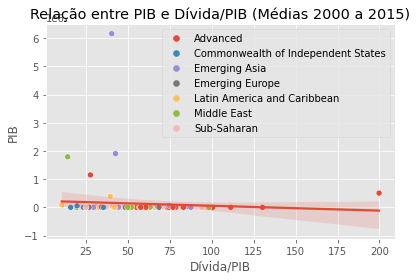

In [ ]:
## Vamos analisar primeiro, sem nenhuma intenção causal e de forma gráfica, 
## a relação entre dívida/PIB e o nível e o crescimento do PIB

## Usando o seaborn, vamos fazer um regplot e um scatterplot com cores por grupo de países
g1 = sns.scatterplot(x="Div_PIB", y="PIB", data=dataMedia, hue="grupo")
g2 = sns.regplot(x="Div_PIB", y="PIB", data=dataMedia, scatter=False)

# Títulos e Eixos
plt.xlabel("Dívida/PIB")
plt.ylabel("PIB")
plt.title("Relação entre PIB e Dívida/PIB (Médias 2000 a 2015)")

# Legenda
plt.legend(frameon=False, facecolor=None)
g1.legend().set_title(None) # removendo título da legenda

# Plottando com limites nos eixos para deixar mais bonitinho
plt.tight_layout()
plt.plot()

# China e Japão atrapalhando um pouco o gráfico...

[]

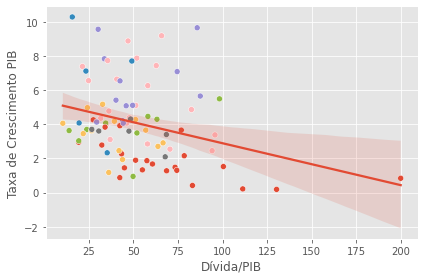

In [ ]:
## Relação entre taxa de crescimento e PIB
g1 = sns.scatterplot(x="Div_PIB", y="Cresc", data=dataMedia, hue="grupo", legend=False)
g2 = sns.regplot(x="Div_PIB", y="Cresc", data=dataMedia, scatter=False)

# Títulos e Eixos
plt.xlabel("Dívida/PIB")
plt.ylabel("Taxa de Crescimento PIB")

# Plottando
plt.tight_layout()
plt.plot()

# Maiores dívidas -> menores taxas de crescimento
# Mas será que isso é um fenômeno causal? E ainda mais, será que é global ou restrito a algum grupo de países?

#### Regressões: Países Avançados

Inicialmente, vamos ver, para a média entre 2000 e 2015, os efeitos da dívida pública sobre o crescimento de países avançados.


Text(0, 0.5, 'Média de Crescimento % do PIB (2000-2015)')

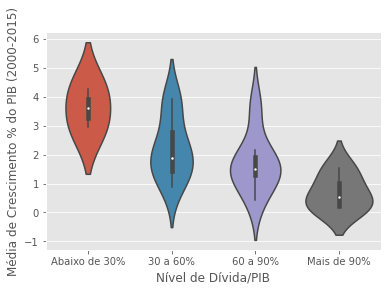

In [ ]:
## Plotando boxplots da relação entre dívida pública e crescimento para países avançados
sns.violinplot(x='Nivel_Dívida', y='Cresc', data=dataMedia.query("grupo == 'Advanced'"))

# Títulos e Eixos
plt.xlabel("Nível de Dívida/PIB")
plt.ylabel("Média de Crescimento % do PIB (2000-2015)")

# Parece haver uma relação negativa entre taxa de crescimento e nível da dívida

In [ ]:
## Contando países avançados em cada grupo
dataMedia.query("grupo == 'Advanced'")["Nivel_Dívida"].value_counts()

30 a 60%         9
60 a 90%         7
Mais de 90%      4
Abaixo de 30%    2
Name: Nivel_Dívida, dtype: int64

In [ ]:
## Criando logs de crescimento e dívida pública
# / 100 : Cresc está em termos percentuais (multiplicada por 100), assim como Div_PIB
# Logaritmizamos as variáveis para termos interpretações em termos percentuais e diminuir problemas de heteroscedasticidade!
dataMedia["log_Cresc"] = np.log(1 + dataMedia["Cresc"] / 100)
dataMedia["log_Div_PIB"] = np.log(dataMedia["Div_PIB"] / 100)

In [ ]:
## Modelo de regressão simples
formula_simples = "log_Cresc ~ 1 + log_Div_PIB"

modelo_simples = ols(formula=formula_simples, data=dataMedia.query("grupo == 'Advanced'")).fit()

print(modelo_simples.summary())

# O coeficiente da relação dívida/PIB é negativo e significativo: mais dívida = menos crescimento
# Interpretação de uma regressão log-log: 10% de aumento na dívida PIB reduz em 1,46% a taxa de crescimento

                            OLS Regression Results                            
Dep. Variable:              log_Cresc   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     16.05
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           0.000693
Time:                        03:51:03   Log-Likelihood:                 73.546
No. Observations:                  22   AIC:                            -143.1
Df Residuals:                      20   BIC:                            -140.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0114      0.003      4.239      

In [ ]:
## Modelo de regressão completo
formula_completa = "log_Cresc ~ 1 + log_Div_PIB + C(Nivel_Dívida)"

modelo_completo = ols(formula=formula_completa, data=dataMedia.query("grupo == 'Advanced'")).fit()

print(modelo_completo.summary())

# Variáveis se tornam insignifcantes, o que se deve tanto ao tamanho da amostra (apenas 22 países)
# quanto ao fato de que apenas dois países tem dívida pública abaixo de 30%, por exemplo

                            OLS Regression Results                            
Dep. Variable:              log_Cresc   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     3.619
Date:                Tue, 07 Dec 2021   Prob (F-statistic):             0.0261
Time:                        03:51:12   Log-Likelihood:                 73.840
No. Observations:                  22   AIC:                            -137.7
Df Residuals:                      17   BIC:                            -132.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Text(0.5, 1.0, 'Dívida Pública e Crescimento - Países Avançados (2000 a 2015)')

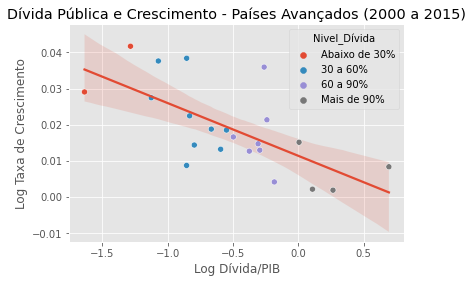

In [ ]:
## Outra forma de visualizarmos essa relação é usando um regplot do seaborn combinado com um scatterplot colorido por faixa de dívida
# Regplot sem desenho dos pontos (scatter=False)
sns.regplot(x="log_Div_PIB", y="log_Cresc", data=dataMedia.query("grupo == 'Advanced'"), scatter=False)

# Scatterplot
sns.scatterplot(x="log_Div_PIB", y="log_Cresc", data=dataMedia.query("grupo == 'Advanced'"), hue="Nivel_Dívida")

# Títulos e Eixos
plt.xlabel("Log Dívida/PIB")
plt.ylabel("Log Taxa de Crescimento")
plt.title("Dívida Pública e Crescimento - Países Avançados (2000 a 2015)")

#### Regressões: Países Emergentes

In [ ]:
## Lista dos países considerados emergentes
lEmergentes = ["Latin America and Caribbean", "Emerging Asia", "Emerging Europe", "Commonwealth of Independent States"]

Text(0, 0.5, 'Média de Crescimento % do PIB (2000-2015)')

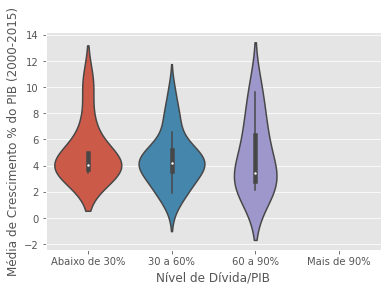

In [ ]:
## Plotando boxplots da relação entre dívida pública e crescimento para países emergentes
sns.violinplot(x='Nivel_Dívida', y='Cresc', data=dataMedia.query("grupo == @lEmergentes"))

# Títulos e Eixos
plt.xlabel("Nível de Dívida/PIB")
plt.ylabel("Média de Crescimento % do PIB (2000-2015)")

# Não parece haver uma relação negativa entre taxa de crescimento e nível da dívida
# Contudo, já temos um problema: não há nenhum país com Div/PIB maior que 90%

In [ ]:
## Modelo de regressão simples
modelo_simples = ols(formula=formula_simples, data=dataMedia.query("grupo == @lEmergentes")).fit()

print(modelo_simples.summary())

# O coeficiente da relação dívida/PIB é negativo e INsignificativo: nos emergentes, não parece haver esse problema,
# o que pode ser atribuído ao baixo nível geral de dívida desses países

# Note também que o intercepto desse grupo de países é maior do que o dos avançados: controlando para a dívida,
# os emergentes possuem taxas de crescimento maiores (sinal, ainda que sem muito rigor técnico, de convergência de Solow)

                            OLS Regression Results                            
Dep. Variable:              log_Cresc   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.2536
Date:                Tue, 07 Dec 2021   Prob (F-statistic):              0.618
Time:                        03:51:31   Log-Likelihood:                 94.124
No. Observations:                  38   AIC:                            -184.2
Df Residuals:                      36   BIC:                            -181.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0419      0.008      5.411      

In [ ]:
## Modelo completo
modelo_completo = ols(formula=formula_completa, data=dataMedia.query("grupo == @lEmergentes")).fit()

print(modelo_completo.summary())

# Variáveis se tornam insignifcantes, o que se deve ao tamanho da amostra (apenas 38 países)
# Note que, como não há país com mais de 90% de dívida, seu coeficiente não é estimado!

                            OLS Regression Results                            
Dep. Variable:              log_Cresc   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.070
Method:                 Least Squares   F-statistic:                    0.1973
Date:                Tue, 07 Dec 2021   Prob (F-statistic):              0.898
Time:                        03:51:35   Log-Likelihood:                 94.318
No. Observations:                  38   AIC:                            -180.6
Df Residuals:                      34   BIC:                            -174.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Text(0.5, 1.0, 'Dívida Pública e Crescimento - Países Emergentes (2000 a 2015)')

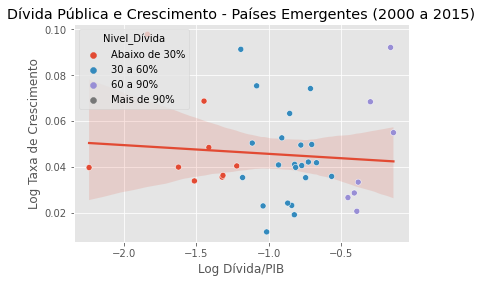

In [ ]:
## Outra forma de visualizarmos essa relação é usando um regplot do seaborn combinado com um scatterplot colorido por faixa de dívida
# Regplot sem desenho dos pontos (scatter=False)
sns.regplot(x="log_Div_PIB", y="log_Cresc", data=dataMedia.query("grupo == @lEmergentes"), scatter=False)

# Scatterplot
sns.scatterplot(x="log_Div_PIB", y="log_Cresc", data=dataMedia.query("grupo == @lEmergentes"), hue="Nivel_Dívida")

# Títulos e Eixos
plt.xlabel("Log Dívida/PIB")
plt.ylabel("Log Taxa de Crescimento")
plt.title("Dívida Pública e Crescimento - Países Emergentes (2000 a 2015)")

# Note que a linha é quase horizontal, como pregam as regressões

#### Regressões: Todos os Países

Text(0, 0.5, 'Média de Crescimento % do PIB (2000-2015)')

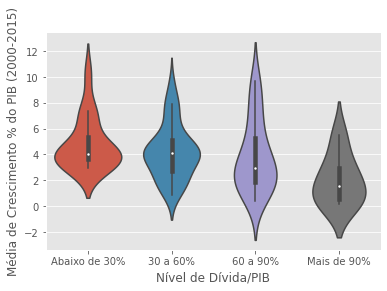

In [ ]:
## Plotando boxplots da relação entre dívida pública e crescimento para todos os países
sns.violinplot(x='Nivel_Dívida', y='Cresc', data=dataMedia)

# Títulos e Eixos
plt.xlabel("Nível de Dívida/PIB")
plt.ylabel("Média de Crescimento % do PIB (2000-2015)")

# Parece haver uma relação negativa entre taxa de crescimento e nível da dívida, mas
# menos pronunciada que a vista quando analisamos apenas os países avançados

In [ ]:
## Contando países em cada grupo
dataMedia["Nivel_Dívida"].value_counts()

30 a 60%         48
60 a 90%         19
Abaixo de 30%    16
Mais de 90%       7
Name: Nivel_Dívida, dtype: int64

In [ ]:
## Modelo de regressão simples
modelo_simples = ols(formula=formula_simples, data=dataMedia).fit()

print(modelo_simples.summary())

# O coeficiente da relação dívida/PIB é negativo e significativo, mas menor que o dos países avançados

                            OLS Regression Results                            
Dep. Variable:              log_Cresc   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.625
Date:                Tue, 07 Dec 2021   Prob (F-statistic):            0.00701
Time:                        03:52:02   Log-Likelihood:                 220.98
No. Observations:                  90   AIC:                            -438.0
Df Residuals:                      88   BIC:                            -433.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0302      0.004      7.387      

In [ ]:
## Modelo completo
modelo_completo = ols(formula=formula_completa, data=dataMedia).fit()

print(modelo_completo.summary())

## Novamente, coeficientes insignificativos

                            OLS Regression Results                            
Dep. Variable:              log_Cresc   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     2.378
Date:                Tue, 07 Dec 2021   Prob (F-statistic):             0.0581
Time:                        03:52:08   Log-Likelihood:                 222.01
No. Observations:                  90   AIC:                            -434.0
Df Residuals:                      85   BIC:                            -421.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Text(0.5, 1.0, 'Dívida Pública e Crescimento (2000 a 2015)')

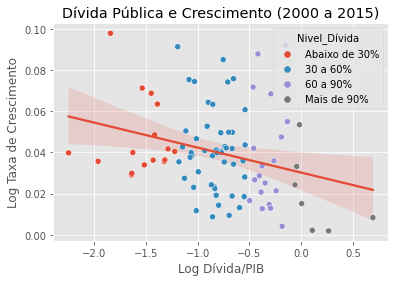

In [ ]:
## Outra forma de visualizarmos essa relação é usando um regplot do seaborn combinado com um scatterplot colorido por faixa de dívida
# Regplot sem desenho dos pontos (scatter=False)
sns.regplot(x="log_Div_PIB", y="log_Cresc", data=dataMedia, scatter=False)

# Scatterplot
sns.scatterplot(x="log_Div_PIB", y="log_Cresc", data=dataMedia, hue="Nivel_Dívida")

# Títulos e Eixos
plt.xlabel("Log Dívida/PIB")
plt.ylabel("Log Taxa de Crescimento")
plt.title("Dívida Pública e Crescimento (2000 a 2015)")

Conclusão: de forma geral, países com maiores dívidas tendem a crescer menos. No entanto, isso não se deve tanto ao nível da dívida - vide coeficientes insignificantes das dummies nas regressões -, mas sim a outros fatores econômicos associados a dívidas maiores.

Nesse sentido, podem-se citar maiores níveis de renda (países avançados crescem menos e são mais endividados), descontrole fiscal...

# Obrigado!